## Modelling for Attacking Mid / Wingers

### Preprocessing

In [43]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

final_df = pd.read_csv("plch_uncorr_elo_v2.csv")

# 1. Filter for "Att Mid / Wingers"
df_att_wingers = final_df[final_df["Position"] == "Att Mid / Wingers"].copy()

df_att_wingers.head(10)

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Carries into Penalty Area,Miscontrols,Dispossessed,Fouls Committed,Fouls Drawn,Offsides,Ball Recoveries,Aerials Won,overall,Elo
0,Mohamed Salah,1992-06-15,PremierLeague,Liverpool,Left,Egypt,Att Mid / Wingers,3371,0.77,0.48,...,3.36,3.10,1.79,0.67,1.04,0.48,2.70,0.24,91,1993
5,Dominik Szoboszlai,2000-10-25,PremierLeague,Liverpool,Right,Hungary,Att Mid / Wingers,2491,0.22,0.22,...,0.65,1.34,0.83,1.59,0.87,0.14,4.81,0.69,82,1993
7,Luis Díaz,1997-01-13,PremierLeague,Liverpool,Right,Colombia,Att Mid / Wingers,2399,0.49,0.19,...,2.10,2.06,1.84,1.80,1.16,0.38,3.94,0.49,85,1993
9,Cody Gakpo,1999-05-07,PremierLeague,Liverpool,Right,Netherlands,Att Mid / Wingers,1935,0.47,0.19,...,1.30,2.09,1.12,0.93,1.44,0.23,3.58,0.79,84,1993
18,Leandro Trossard,1994-12-04,PremierLeague,Arsenal,Right,Belgium,Att Mid / Wingers,2546,0.28,0.25,...,1.06,2.33,1.84,0.95,1.63,0.21,3.68,0.21,83,1993
22,Gabriel Martinelli,2001-06-18,PremierLeague,Arsenal,Right,Brazil,Att Mid / Wingers,2290,0.31,0.16,...,2.52,1.97,1.49,0.63,0.83,0.31,3.07,0.67,82,1993
24,Bukayo Saka,2001-09-05,PremierLeague,Arsenal,Left,England,Att Mid / Wingers,1729,0.31,0.52,...,2.65,1.77,2.08,0.78,2.03,0.36,3.64,0.52,88,1993
39,Sávio,2004-04-10,PremierLeague,Manchester City,Left,Brazil,Att Mid / Wingers,1766,0.05,0.41,...,3.82,2.14,1.94,0.87,1.43,0.15,4.03,0.05,70,1960
40,Phil Foden,2000-05-28,PremierLeague,Manchester City,Left,England,Att Mid / Wingers,1777,0.35,0.10,...,0.86,1.82,1.57,0.25,1.72,0.15,3.09,0.15,86,1960
41,Kevin De Bruyne,1991-06-28,PremierLeague,Manchester City,Right,Belgium,Att Mid / Wingers,1702,0.21,0.37,...,1.06,1.37,1.48,0.90,0.95,0.26,3.38,0.26,89,1960


In [2]:
# 2. Define target and input features //
target = "overall"
drop_cols = ["Player", "Birthdate", "League", "Club", "Nationality", "Footed", "Position", "Minutes", "Club_x", "Aerials Lost"]

attacking_mids_wingers_features = [
    'Goals', 'Assists', 'npxG + xAG',                 # Direct goal involvement and advanced expected contribution
    'Shots on Target', 'Goals/Shot',                  # Shooting efficiency and accuracy
    'Average Shot Distance',                          # Indicates shot selection and tactical role
    'Progressive Carries', 'Progressive Carrying Distance', # Ball progression via dribbling
    'Carries into Final Third', 'Carries into Penalty Area', # Advanced movement into dangerous zones
    'Successful Take-Ons', 'Successful Take-On %',    # 1v1 dribbling ability
    'Touches (Att 3rd)', 'Touches (Att Pen)',         # Presence in attacking areas
    'Pass Completion %', 'Live-ball Passes',          # Ball retention and passing in play
    'Progressive Passes', 'Progressive Passing Distance', # Forward passing impact
    'Passes into Final Third', 'Passes into Penalty Area', # Penetrative passing
    'Crosses', 'Crosses into Penalty Area',           # Creating chances from wide areas
    'Through Balls', 'Switches',                      # Creativity and vision
    'SCA (Live-ball Pass)', 'SCA (Take-On)', 'SCA (Shot)', # Shot-creating actions via various means
    'GCA (Live-ball Pass)', 'GCA (Take-On)', 'GCA (Shot)', # Goal-creating actions
    'Miscontrols', 'Dispossessed',                    # Ball security under pressure
    'Fouls Drawn',                                    # Ability to win set pieces
    'Elo'                                             # Club/league strength context
]

In [3]:
X = df_att_wingers.drop(columns=drop_cols + [target], errors="ignore")
X =df_att_wingers[attacking_mids_wingers_features]
y = df_att_wingers[target]

numeric_features = X.select_dtypes(include="number").columns.tolist()


# 3. Preprocessing pipeline // min-maxscaling for numeric features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
X.columns

Index(['Goals', 'Assists', 'npxG + xAG', 'Shots on Target', 'Goals/Shot',
       'Average Shot Distance', 'Progressive Carries',
       'Progressive Carrying Distance', 'Carries into Final Third',
       'Carries into Penalty Area', 'Successful Take-Ons',
       'Successful Take-On %', 'Touches (Att 3rd)', 'Touches (Att Pen)',
       'Pass Completion %', 'Live-ball Passes', 'Progressive Passes',
       'Progressive Passing Distance', 'Passes into Final Third',
       'Passes into Penalty Area', 'Crosses', 'Crosses into Penalty Area',
       'Through Balls', 'Switches', 'SCA (Live-ball Pass)', 'SCA (Take-On)',
       'SCA (Shot)', 'GCA (Live-ball Pass)', 'GCA (Take-On)', 'GCA (Shot)',
       'Miscontrols', 'Dispossessed', 'Fouls Drawn', 'Elo'],
      dtype='object')

In [5]:
# 5. Initiate method that will train and evaluate different models 

def evaluate_model(
    name,
    model,
    preprocessor_override=None,
    X_train_override=None,
    X_test_override=None,
    y_train_override=None,
    y_test_override=None
):
    # Use overrides or fall back to global variables
    X_train_local = X_train_override if X_train_override is not None else X_train
    X_test_local = X_test_override if X_test_override is not None else X_test
    y_train_local = y_train_override if y_train_override is not None else y_train
    y_test_local = y_test_override if y_test_override is not None else y_test
    preprocessor_local = preprocessor_override if preprocessor_override is not None else preprocessor

    # Define pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor_local),
        ("regressor", model)
    ])

    # Fit and predict
    pipe.fit(X_train_local, y_train_local)
    y_pred = pipe.predict(X_test_local)

    # Cross-validation (on full data)
    cv_score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_cv_mae = -np.mean(cv_score)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test_local, y_pred),
        "RMSE": root_mean_squared_error(y_test_local, y_pred),
        "5-CV": mean_cv_mae,
        "R2": r2_score(y_test_local, y_pred),
        "Pipeline": pipe
    }

### Linear Models

In [6]:
results = []

# Lasso
results.append(evaluate_model("Lasso", LassoCV(cv=5)))

# Get the trained Lasso pipeline
lasso_pipe = results[0]["Pipeline"]  # Assuming Lasso is first in results

# Access the Lasso model and preprocessor
lasso_model = lasso_pipe.named_steps["regressor"]
scaler = lasso_pipe.named_steps["preprocess"]

# Get feature names from preprocessor
feature_names = scaler.transformers_[0][2]  # ['num', scaler, [feature list]]

# Get non-zero coefficients
import pandas as pd
coefs = pd.Series(lasso_model.coef_, index=feature_names)
non_zero_coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("Non-zero Lasso Coefficients:")
print(non_zero_coefs)

Non-zero Lasso Coefficients:
Elo                             3.305903
Goals                           1.343677
Goals/Shot                     -0.550634
npxG + xAG                      0.523620
Assists                         0.398193
Progressive Passing Distance    0.344486
Through Balls                   0.222549
Pass Completion %               0.194147
SCA (Live-ball Pass)            0.165875
GCA (Take-On)                  -0.119305
Progressive Passes              0.089833
SCA (Shot)                      0.069126
Progressive Carries            -0.050997
SCA (Take-On)                  -0.016944
dtype: float64


In [7]:
# Lasso + XGBoost
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ('lasso', LassoCV(cv=5))
])
lasso.fit(X_train, y_train)
selected_features = np.array(numeric_features)[lasso.named_steps["lasso"].coef_ != 0]

selected_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_features.tolist())
])

results.append(evaluate_model(
    name="Lasso+XGBoost",
    model=XGBRegressor(n_estimators=100),
    preprocessor_override=selected_preprocessor,
    X_train_override=X_train[selected_features],
    X_test_override=X_test[selected_features],
    y_train_override=y_train,
    y_test_override=y_test
))

### Elastic Net with correlated features to target variable

In [8]:
# Select top k features with strongest correlation to target
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_feature_names_out(input_features=X.columns)

# Train/test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X[selected_features], y, test_size=0.15
)

# Preprocessing and model
preprocessor_sel = ColumnTransformer([
    ("num", StandardScaler(), selected_features)
])
model = ElasticNetCV(cv=5, max_iter=5000)

pipeline = Pipeline([
    ("preprocess", preprocessor_sel),
    ("regressor", model)
])

# Fit and predict
pipeline.fit(X_train_sel, y_train_sel)
y_pred_sel = pipeline.predict(X_test_sel)

# Evaluate and store
results.append({
    "Model": "ElasticNet (Top15 SelectKBest)",
    "MAE": mean_absolute_error(y_test_sel, y_pred_sel),
    "RMSE": root_mean_squared_error(y_test_sel, y_pred_sel),
    "5-CV": -cross_val_score(pipeline, X[selected_features], y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test_sel, y_pred_sel),
    "Pipeline": pipeline
})

### Stacked Model

In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# Define base and meta learners
base_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=42))
meta_model = XGBRegressor(n_estimators=100)

# Wrap ElasticNet and XGBoost in stacking regressor
stacked_model = StackingRegressor(
    estimators=[("elasticnet", base_model)],
    final_estimator=meta_model,
    passthrough=True  # includes original features as well
)

# Train/test split stays the same
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Evaluate
results.append({
    "Model": "ElasticNet→XGBoost (Stacked)",
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": root_mean_squared_error(y_test, y_pred_stack),
    "5-CV": cross_val_score(stacked_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_stack),
    "Pipeline": stacked_model
})

### Hyperparamater tuning for RF & XG

In [10]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()  # Optuna minimizes

# Run the study
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=100)

# Best model
best_rf = RandomForestRegressor(**rf_study.best_params)

[I 2025-06-12 14:38:53,310] A new study created in memory with name: no-name-ad82a041-72a6-4299-aa69-b3247de755eb
[I 2025-06-12 14:38:57,587] Trial 0 finished with value: 2.754598916851222 and parameters: {'n_estimators': 959, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 2.754598916851222.
[I 2025-06-12 14:38:58,574] Trial 1 finished with value: 2.848116898637799 and parameters: {'n_estimators': 695, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 2.754598916851222.
[I 2025-06-12 14:38:58,822] Trial 2 finished with value: 2.7850873155965603 and parameters: {'n_estimators': 133, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 2.754598916851222.
[I 2025-06-12 14:38:59,846] Trial 3 finished with value: 2.804856980202601 and parameters: {'n_estimators': 773, 'max_depth': 4, 'min_samples_s

In [11]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])

# Fit and predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

results.append({
    "Model": "RandomForest (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "5-CV": - cross_val_score(rf_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_rf),
    "Pipeline": rf_pipeline
})

In [12]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    model = XGBRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()

# Run the study
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model
best_xgb = XGBRegressor(**xgb_study.best_params)

[I 2025-06-12 14:39:58,692] A new study created in memory with name: no-name-6314742d-179d-4f2e-8e6d-481f1b24a0a4
[I 2025-06-12 14:39:59,639] Trial 0 finished with value: 2.772306599336512 and parameters: {'n_estimators': 729, 'max_depth': 8, 'learning_rate': 0.031989679028662156, 'subsample': 0.7263776487357593, 'colsample_bytree': 0.6027011726205398, 'gamma': 0.13301297641865106, 'reg_alpha': 0.14836738573597974, 'reg_lambda': 0.6089059520614397}. Best is trial 0 with value: 2.772306599336512.
[I 2025-06-12 14:40:00,173] Trial 1 finished with value: 2.686728483257872 and parameters: {'n_estimators': 837, 'max_depth': 13, 'learning_rate': 0.2036137680458079, 'subsample': 0.6956140600480889, 'colsample_bytree': 0.850060303579557, 'gamma': 2.3850952633411184, 'reg_alpha': 0.10339299989808726, 'reg_lambda': 0.7504915758717665}. Best is trial 1 with value: 2.686728483257872.
[I 2025-06-12 14:40:00,651] Trial 2 finished with value: 2.7111363688042243 and parameters: {'n_estimators': 285, '

In [13]:
# Create pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_xgb)
])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

results.append({
    "Model": "XGBoost (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "5-CV": -cross_val_score(xgb_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_xgb),
    "Pipeline": rf_pipeline
})

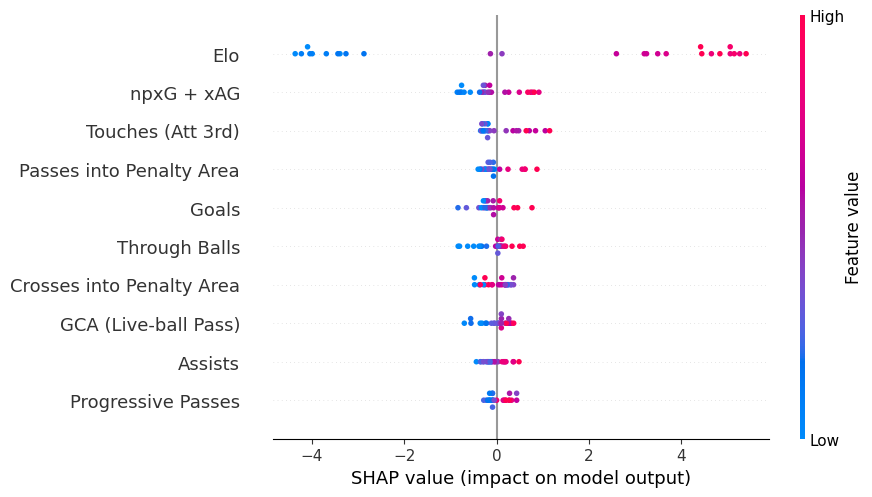

In [14]:
import shap
import numpy as np
import pandas as pd

# Extract model and transformed data
xgb_model = xgb_pipeline.named_steps["regressor"]
X_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract feature names used in preprocessing
feature_names = xgb_pipeline.named_steps["preprocessor"].transformers_[0][2]

# Convert transformed data to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_abs_shap)[-10:]

# Filter SHAP values to top 10 features
shap_values_top = shap_values[:, top_10_indices]

# Plot SHAP summary (beeswarm) for top 10 features
shap.plots.beeswarm(shap_values_top)


### Modelling Results 

In [25]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by MAE (ascending)
results_df_sorted = results_df.sort_values(by="MAE", ascending=True)

# Display selected columns (optional)
display_cols = ["Model", "MAE", "RMSE", "5-CV", "R2"]
print(results_df_sorted[display_cols])

                            Model       MAE      RMSE      5-CV        R2
5                XGBoost (Optuna)  1.968400  2.419521  2.448809  0.755673
2  ElasticNet (Top15 SelectKBest)  2.027545  2.997807  2.386124  0.645415
4           RandomForest (Optuna)  2.126949  2.574875  2.732992  0.723290
1                   Lasso+XGBoost  2.283221  2.767267  3.061211  0.680394
0                           Lasso  2.285509  2.921562  2.361782  0.643760
3    ElasticNet→XGBoost (Stacked)  2.933743  4.147749 -3.031970  0.281979


### Model Saving & Shap Plots

In [34]:
import joblib

# Get the best model (lowest MAE)
best_model = results_df_sorted.iloc[0]["Pipeline"]

# Save to disk
joblib.dump(best_model, "best_model_am.joblib")

['best_model_am.joblib']

Feature names: 34, Importances: 34
                          feature  importance
33                            Elo    0.629453
2                      npxG + xAG    0.042437
24           SCA (Live-ball Pass)    0.041250
0                           Goals    0.032710
22                  Through Balls    0.028650
27           GCA (Live-ball Pass)    0.016208
12              Touches (Att 3rd)    0.016113
19       Passes into Penalty Area    0.014589
11           Successful Take-On %    0.012804
5           Average Shot Distance    0.012281
8        Carries into Final Third    0.010596
16             Progressive Passes    0.009973
3                 Shots on Target    0.009936
14              Pass Completion %    0.009865
26                     SCA (Shot)    0.008843
30                    Miscontrols    0.008388
13              Touches (Att Pen)    0.007837
4                      Goals/Shot    0.007773
1                         Assists    0.007508
10            Successful Take-Ons    0.007202

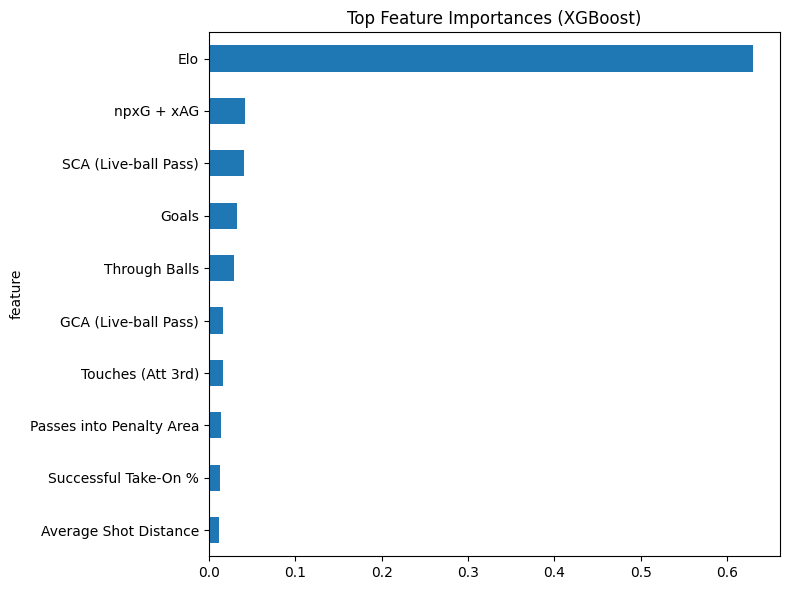

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Access the fitted pipeline
preprocessor = best_model.named_steps['preprocessor']

# Get the feature names from the numeric transformer
feature_names = preprocessor.transformers_[0][2]  # This works if your first transformer is 'num'

# Access XGBoost model (assume it's called 'xgb' or is the last step)
xgb = (
    best_model.named_steps['xgb']
    if 'xgb' in best_model.named_steps
    else best_model[-1]
)

# Get feature importances (gain-based)
importances = xgb.feature_importances_

# Sanity check
print(f"Feature names: {len(feature_names)}, Importances: {len(importances)}")

# DataFrame for easy visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Optional: Plot top 10
importance_df.head(10).plot(
    x='feature', y='importance', kind='barh', figsize=(8,6), legend=False
)
plt.title('Top Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


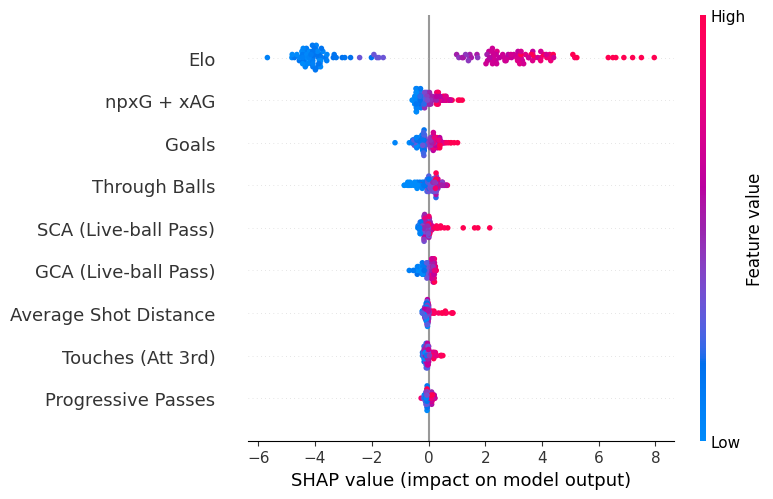

In [20]:
import shap

# Transform your training data as the model sees it
X_proc = preprocessor.transform(X_train[feature_names])

# Fit SHAP TreeExplainer on the trained XGBoost model
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_proc)

# SHAP summary plot: show only top N features
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values, 
    features=X_proc, 
    feature_names=feature_names, 
    show=False, 
    max_display=9  # Adjust for desired number of top features
)  # Adjust if your values are wider/narrower
plt.show()


In [35]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Goals', 'Assists',
                                                   'npxG + xAG',
                                                   'Shots on Target',
                                                   'Goals/Shot',
                                                   'Average Shot Distance',
                                                   'Progressive Carries',
                                                   'Progressive Carrying '
                                                   'Distance',
                                                   'Carries into Final Third',
                                                   'Carries into Penalty Area',
                                                   'Successful Take-Ons',
                                                   'Successful Take-On %',
                                                   'Touches (Att 3rd)',
                                                   'Touches (Att Pen)',
                                                   '...
                                                   'Progressive Passing '
                                                   'Distance',
                                                   'Passes into Final Third',
                                                   'Passes into Penalty Area',
                                                   'Crosses',
                                                   'Crosses into Penalty Area',
                                                   'Through Balls', 'Switches',
                                                   'SCA (Live-ball Pass)',
                                                   'SCA (Take-On)',
                                                   'SCA (Shot)',
                                                   'GCA (Live-ball Pass)',
                                                   'GCA (Take-On)',
                                                   'GCA (Shot)', ...])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, max_features=None,
                                       min_samples_split=3,
                                       n_estimators=354))])

In [47]:
# Transform your training data as the model sees it
X_zssay = preprocessor.transform(X[feature_names])

y_zssay = best_model.predict(X)

y_zssay

array([87.62377589, 82.26887275, 84.4667003 , 82.8429513 , 82.46510627,
       82.00876043, 86.83919828, 75.11355932, 83.48162069, 82.74203026,
       79.20794898, 81.62454937, 79.02492602, 84.99728948, 79.24073652,
       77.70176314, 79.89993074, 78.96810198, 78.49318576, 79.13003939,
       79.92001317, 79.36334685, 78.19355215, 78.68265258, 78.80199846,
       79.74482516, 75.35026151, 79.96449949, 78.87908543, 77.21941679,
       77.0250948 , 78.43474199, 77.41546266, 77.82751627, 76.82077973,
       78.28290808, 78.59026774, 78.93304727, 77.06170729, 77.58466232,
       76.22686   , 80.85352633, 78.96813676, 76.8021148 , 79.33095231,
       77.33140759, 76.40002936, 76.63352859, 76.21028128, 79.7243967 ,
       78.08616981, 76.3842903 , 74.35722192, 77.61420914, 74.89199954,
       77.7959297 , 74.94812795, 77.79734517, 75.8394613 , 84.24656309,
       77.65134051, 78.79435306, 77.18463295, 76.53146174, 75.06029838,
       75.2335866 , 75.18598281, 76.42231007, 75.57931237, 78.69

In [48]:
y_zssay_df = best_model.predict(df_att_wingers)

y_zssay_df

array([87.62377589, 82.26887275, 84.4667003 , 82.8429513 , 82.46510627,
       82.00876043, 86.83919828, 75.11355932, 83.48162069, 82.74203026,
       79.20794898, 81.62454937, 79.02492602, 84.99728948, 79.24073652,
       77.70176314, 79.89993074, 78.96810198, 78.49318576, 79.13003939,
       79.92001317, 79.36334685, 78.19355215, 78.68265258, 78.80199846,
       79.74482516, 75.35026151, 79.96449949, 78.87908543, 77.21941679,
       77.0250948 , 78.43474199, 77.41546266, 77.82751627, 76.82077973,
       78.28290808, 78.59026774, 78.93304727, 77.06170729, 77.58466232,
       76.22686   , 80.85352633, 78.96813676, 76.8021148 , 79.33095231,
       77.33140759, 76.40002936, 76.63352859, 76.21028128, 79.7243967 ,
       78.08616981, 76.3842903 , 74.35722192, 77.61420914, 74.89199954,
       77.7959297 , 74.94812795, 77.79734517, 75.8394613 , 84.24656309,
       77.65134051, 78.79435306, 77.18463295, 76.53146174, 75.06029838,
       75.2335866 , 75.18598281, 76.42231007, 75.57931237, 78.69

## Clustering AM

### Concatenate all data players from all leagues

In [55]:
import pandas as pd
import glob
import os

# Path to the folder containing the CSV files
folder_path = 'players_data_clean/'

# Get list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Read and concatenate all CSV files into a single DataFrame
df_combined = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Check the resulting DataFrame
df_combined

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Fouls Committed,Fouls Drawn,Offsides,Penalty Kicks Won,Penalty Kicks Conceded,Own Goals,Ball Recoveries,Aerials Won,Aerials Lost,% of Aerials Won
0,Amir Rrahmani,1994-02-24,SerieA,Napoli,Right,Kosovo,Center Backs,3406,0.03,0.08,...,1.11,0.42,0.00,0.00,0.00,0.03,3.57,3.28,1.45,69.3
1,Giovanni Di Lorenzo,1993-08-04,SerieA,Napoli,Right,Italy,Fullbacks,3330,0.08,0.05,...,1.24,1.38,0.14,0.00,0.00,0.00,2.54,1.22,1.24,49.5
2,Romelu Lukaku,1993-05-13,SerieA,Napoli,Left,Belgium,Forwards,2843,0.44,0.32,...,1.49,1.14,0.76,0.00,0.00,0.00,1.08,1.33,1.77,42.9
3,Matteo Politano,1993-08-03,SerieA,Napoli,Left,Italy,Att Mid / Wingers,2804,0.10,0.13,...,0.45,1.00,0.19,0.03,0.00,0.00,3.05,0.19,0.64,23.1
4,Scott McTominay,1996-12-08,SerieA,Napoli,Right,Scotland,Midfielders,2938,0.37,0.12,...,1.38,1.84,0.15,0.03,0.00,0.00,4.38,2.02,1.53,56.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,Yukinari Sugawara,2000-06-28,PremierLeague,Southampton,Right,Japan,Fullbacks,1557,0.06,0.06,...,0.87,0.58,0.23,0.00,0.12,0.00,2.54,0.29,0.52,35.7
2433,Adam Armstrong,1997-02-10,PremierLeague,West Bromwich Albion,Right,England,Forwards,1248,0.14,0.14,...,0.87,0.36,0.65,0.00,0.00,0.00,1.66,0.36,0.65,35.7
2434,James Bree,1997-10-11,PremierLeague,Southampton,Right,England,Center Backs,1075,0.00,0.08,...,0.33,0.42,0.00,0.00,0.00,0.00,5.44,1.00,0.59,63.2
2435,Paul Onuachu,1994-05-28,PremierLeague,Southampton,Right,Nigeria,Forwards,1050,0.34,0.09,...,2.40,1.37,0.86,0.00,0.00,0.00,1.63,7.97,5.06,61.2


In [ ]:
# Check for NaN values in each column
nan_counts = df_combined.isna().sum()

# Display columns with NaNs and their counts
nan_columns = nan_counts[nan_counts > 0]

if nan_columns.empty:
    print("No NaN values found!")
else:
    print("NaN values detected:")
    print(nan_columns)

No NaN values found!


### Merge clubs' elos for modelling 

In [ ]:
elo_df = pd.read_csv("elo_clubs/Elo_Club_VF.csv", sep=';')

In [ ]:
from fuzzywuzzy import process

def get_best_match(name, choices):
    result = process.extractOne(name, choices)
    return result[0] 

# Apply fuzzy matching to club names with the same 
df_combined["Club_fuzzy"] = df_combined["Club"].apply(
    lambda x: get_best_match(x, elo_df["Club"].unique())
)

# Merge the matched names
final_df = pd.merge(df_combined, elo_df, left_on='Club_fuzzy', right_on='Club', how='left')
final_df.drop(columns=['Club_fuzzy', 'Club_y'], inplace=True)
final_df.rename(columns={'Club_x': 'Club'}, inplace=True)

In [ ]:
final_df

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Fouls Drawn,Offsides,Penalty Kicks Won,Penalty Kicks Conceded,Own Goals,Ball Recoveries,Aerials Won,Aerials Lost,% of Aerials Won,Elo
0,Amir Rrahmani,1994-02-24,SerieA,Napoli,Right,Kosovo,Center Backs,3406,0.03,0.08,...,0.42,0.00,0.00,0.00,0.03,3.57,3.28,1.45,69.3,1838
1,Giovanni Di Lorenzo,1993-08-04,SerieA,Napoli,Right,Italy,Fullbacks,3330,0.08,0.05,...,1.38,0.14,0.00,0.00,0.00,2.54,1.22,1.24,49.5,1838
2,Romelu Lukaku,1993-05-13,SerieA,Napoli,Left,Belgium,Forwards,2843,0.44,0.32,...,1.14,0.76,0.00,0.00,0.00,1.08,1.33,1.77,42.9,1838
3,Matteo Politano,1993-08-03,SerieA,Napoli,Left,Italy,Att Mid / Wingers,2804,0.10,0.13,...,1.00,0.19,0.03,0.00,0.00,3.05,0.19,0.64,23.1,1838
4,Scott McTominay,1996-12-08,SerieA,Napoli,Right,Scotland,Midfielders,2938,0.37,0.12,...,1.84,0.15,0.03,0.00,0.00,4.38,2.02,1.53,56.9,1838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,Yukinari Sugawara,2000-06-28,PremierLeague,Southampton,Right,Japan,Fullbacks,1557,0.06,0.06,...,0.58,0.23,0.00,0.12,0.00,2.54,0.29,0.52,35.7,1782
2433,Adam Armstrong,1997-02-10,PremierLeague,West Bromwich Albion,Right,England,Forwards,1248,0.14,0.14,...,0.36,0.65,0.00,0.00,0.00,1.66,0.36,0.65,35.7,1538
2434,James Bree,1997-10-11,PremierLeague,Southampton,Right,England,Center Backs,1075,0.00,0.08,...,0.42,0.00,0.00,0.00,0.00,5.44,1.00,0.59,63.2,1782
2435,Paul Onuachu,1994-05-28,PremierLeague,Southampton,Right,Nigeria,Forwards,1050,0.34,0.09,...,1.37,0.86,0.00,0.00,0.00,1.63,7.97,5.06,61.2,1782


In [ ]:
final_df_am = final_df[final_df["Position"] == "Att Mid / Wingers"].copy()

In [ ]:
final_df_am

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Fouls Drawn,Offsides,Penalty Kicks Won,Penalty Kicks Conceded,Own Goals,Ball Recoveries,Aerials Won,Aerials Lost,% of Aerials Won,Elo
3,Matteo Politano,1993-08-03,SerieA,Napoli,Left,Italy,Att Mid / Wingers,2804,0.10,0.13,...,1.00,0.19,0.03,0.0,0.0,3.05,0.19,0.64,23.1,1838
9,Khvicha Kvaratskhelia,2001-02-12,SerieA,Paris Saint-Germain,Right,Georgia,Att Mid / Wingers,1178,0.38,0.23,...,2.52,0.00,0.00,0.0,0.0,3.44,0.31,0.38,44.4,1975
10,David Neres,1997-03-03,SerieA,Napoli,Left,Brazil,Att Mid / Wingers,1283,0.14,0.28,...,0.70,0.28,0.00,0.0,0.0,3.65,0.21,0.70,23.1,1838
12,Giacomo Raspadori,2000-02-18,SerieA,Napoli,Right,Italy,Att Mid / Wingers,1103,0.49,0.08,...,1.63,0.08,0.00,0.0,0.0,3.51,0.41,0.90,31.3,1838
14,Michael Folorunsho,1998-02-07,SerieA,Fiorentina,Right,Italy,Att Mid / Wingers,685,0.00,0.00,...,3.15,0.00,0.00,0.0,0.0,4.07,2.37,1.71,58.1,1757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417,Wes Burns,1994-11-23,PremierLeague,Ipswich Town,Right,Wales,Att Mid / Wingers,926,0.00,0.10,...,1.07,0.00,0.00,0.0,0.0,4.86,0.78,2.04,27.6,1797
2418,Conor Chaplin,1997-02-16,PremierLeague,Ipswich Town,Right,England,Att Mid / Wingers,857,0.11,0.11,...,0.74,0.00,0.00,0.0,0.0,2.84,0.32,0.95,25.0,1797
2419,Nathan Broadhead,1998-04-05,PremierLeague,Ipswich Town,Right,Wales,Att Mid / Wingers,702,0.26,0.00,...,1.67,0.26,0.00,0.0,0.0,4.10,0.13,1.28,9.1,1797
2422,Mateus Fernandes,2004-07-10,PremierLeague,Southampton,Right,Portugal,Att Mid / Wingers,2909,0.06,0.12,...,1.70,0.12,0.00,0.0,0.0,5.54,0.46,0.28,62.5,1782


In [ ]:
# Check for NaN values in each column
nan_counts = final_df.isna().sum()

# Display columns with NaNs and their counts
nan_columns = nan_counts[nan_counts > 0]

if nan_columns.empty:
    print("No NaN values found!")
else:
    print("NaN values detected:")
    print(nan_columns)

No NaN values found!
